https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

## An End-to-End Project on Time Series Analysis and Forecasting with Python

### The Data

We are using Superstore sales data that can be downloaded from the following
https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
import itertools
warnings.filterwarnings("ignore")

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [2]:
df = pd.read_excel("superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [3]:
display(furniture.head(), furniture.columns)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [4]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

We have almost 4-year furniture sales data.

### Data Preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [5]:
# drop unwanted columns

cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 
        'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 
        'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [6]:
# check missing values

furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [7]:
# aggregate data by day

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture

,Order Date,Sales
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180


### Time Series Data

In [8]:
# indexing with time

furniture.set_index('Order Date', inplace=True)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

For more DateOffset string options see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

In [9]:
sales = furniture['Sales'].resample('MS').mean()

In [10]:
sales['2014']

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
Freq: MS, Name: Sales, dtype: float64

<AxesSubplot:xlabel='Order Date'>

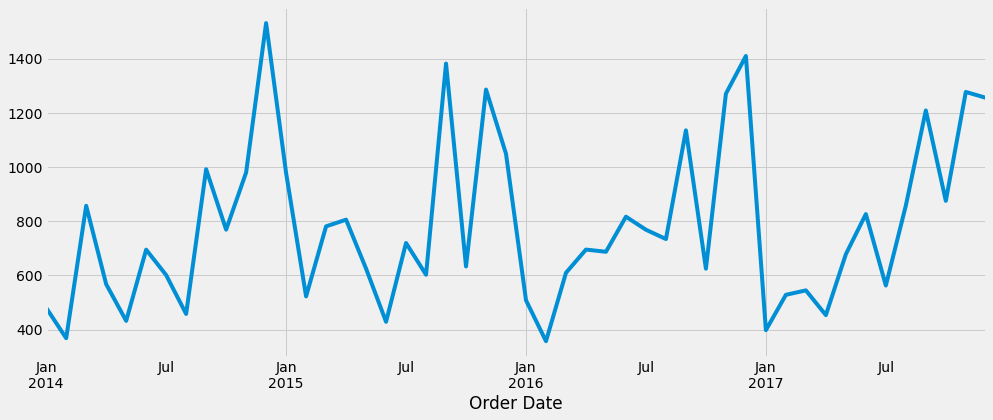

In [11]:
# ts plot

sales.plot(figsize=(15,6))

The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

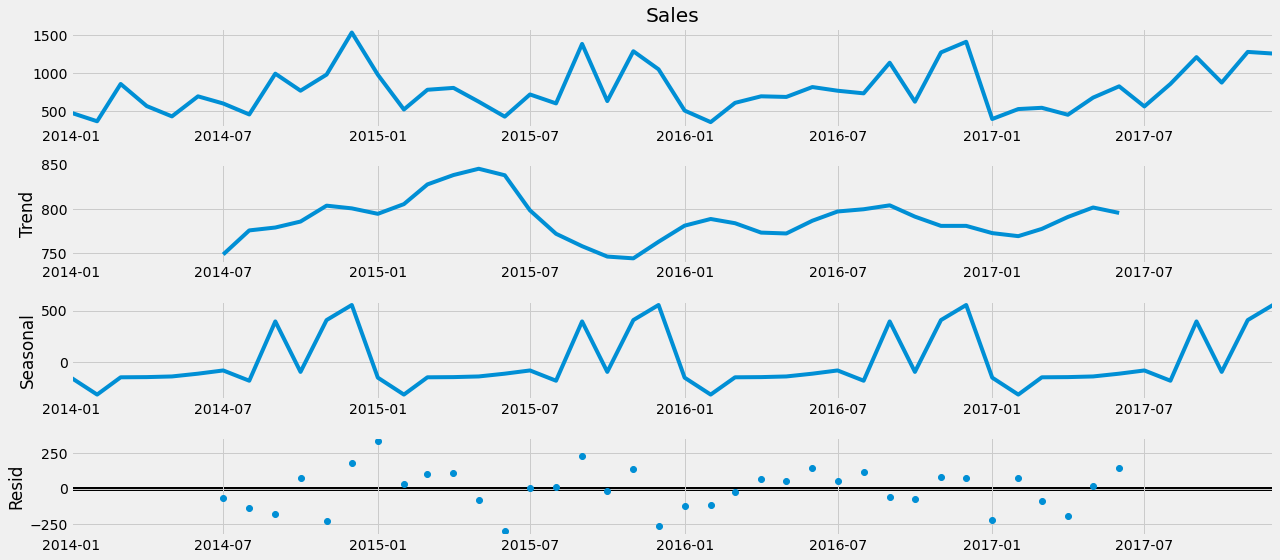

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(sales, model='additive')
fig = decomposition.plot()
plt.show()

### Time Series Forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [14]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [15]:
# parameter search

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1436.7096275959661
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793748
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1131.1862176526117
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280301923
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758111
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2677.925835775167
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091534
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673292
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5890624047003
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2513.2838482013117
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576517064
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1508.9266604104025
ARIM

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.58

In [16]:
# fit the model

mod = sm.tsa.statespace.SARIMAX(sales,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9985     12.414     -0.080      0.936     -25.329      23.332
ma.S.L12      -0.9748      8.885     -0.110      0.913     -18.390      16.440
sigma2      2.757e+04   4.87e+05      0.057      0.955   -9.27e+05    9.83e+05


We should always run model diagnostics to investigate any unusual behavior.

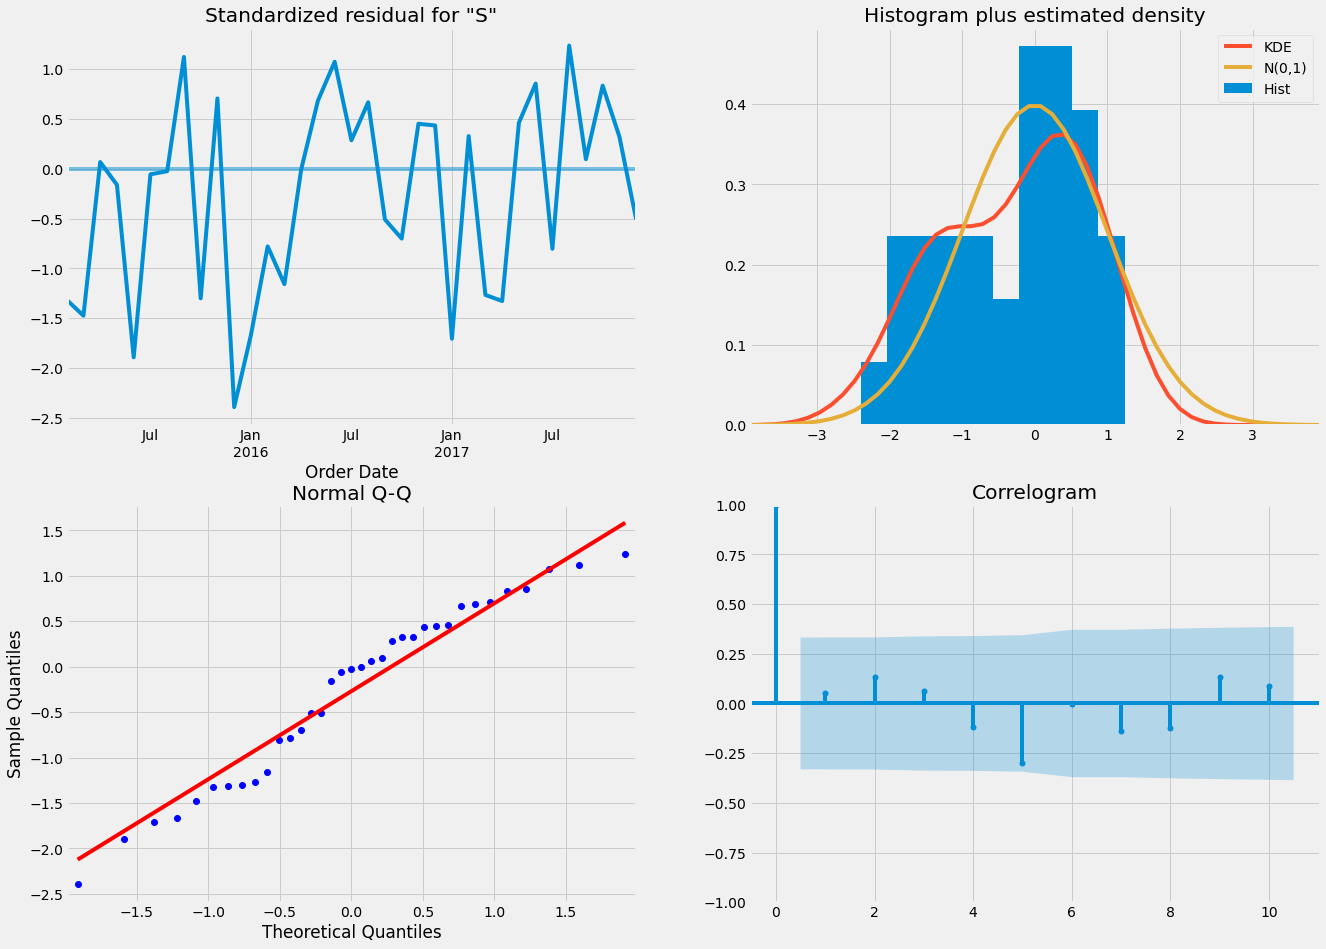

In [17]:
results.plot_diagnostics(figsize=(20, 15))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

### Validating Forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

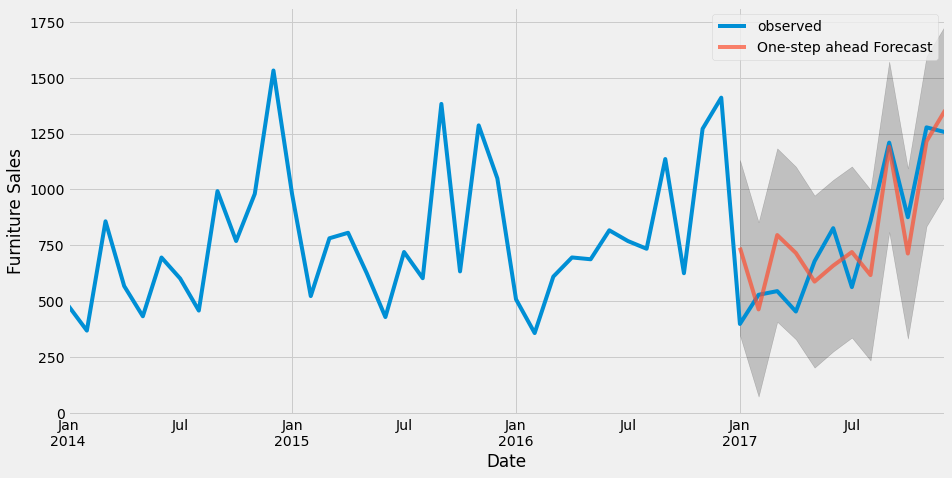

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_interval = pred.conf_int()

ax = sales['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_interval.index,
                pred_interval.iloc[:, 0],
                pred_interval.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [19]:
y_forecasted = pred.predicted_mean
y_truth = sales['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 34361.46


In [20]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 185.37


Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales.

### Producing and Visualizing Forecasts

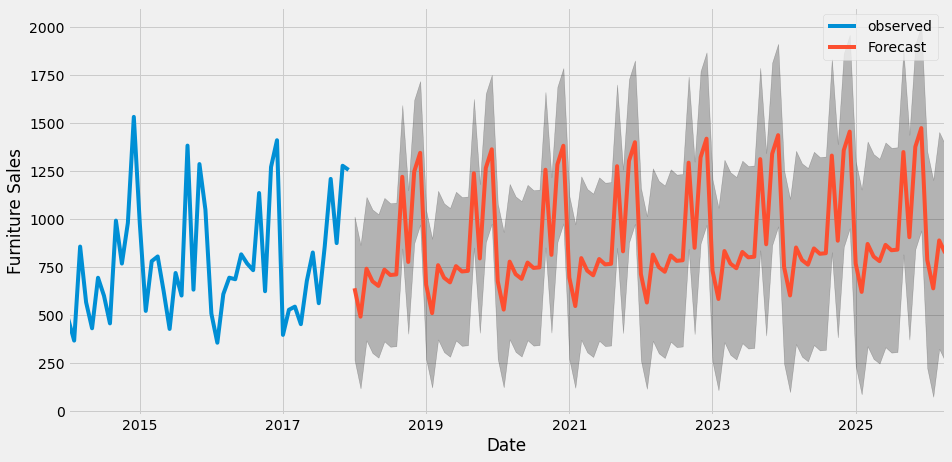

In [21]:
pred_uc = results.get_forecast(steps=100)
pred_interval = pred_uc.conf_int()

ax = sales.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_interval.index,
                pred_interval.iloc[:, 0],
                pred_interval.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

### Time Series of Furniture vs. Office Supplies

According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [22]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

We are going to compare two categories’ sales in the same time period. This means combine two data frames into one and plot these two categories’ time series into one plot.

In [23]:
# merge the two dataframe

cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 
        'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 
        'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


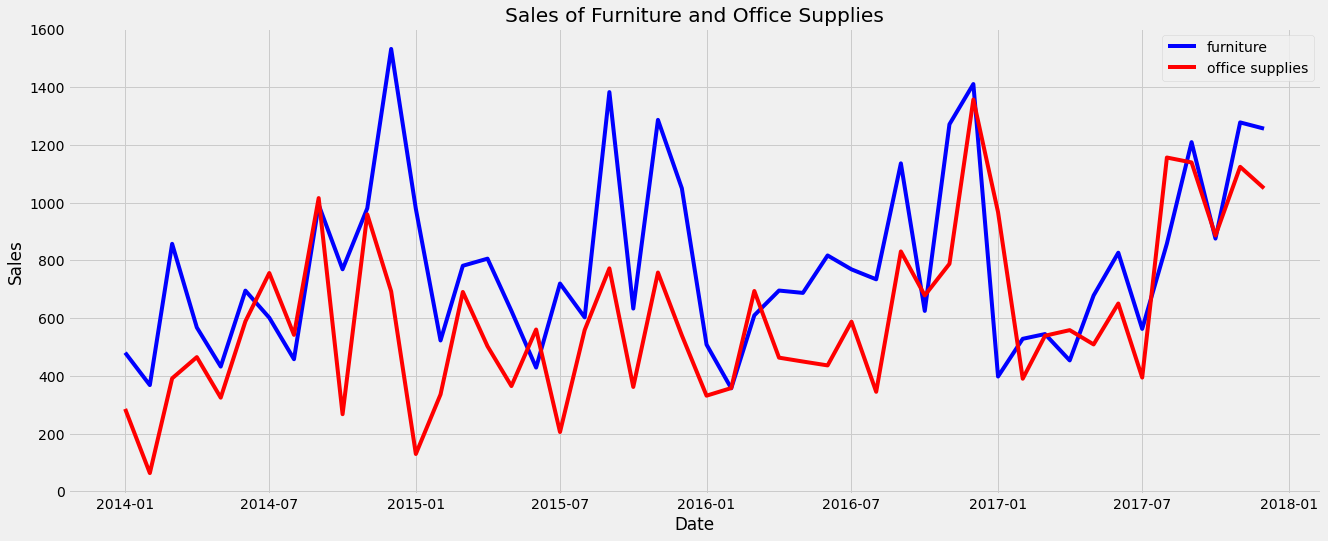

In [24]:
# plot the two series alongside with each other

plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

It seems the average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. 

Occasionally, office supplies passed furniture on average daily sales. Let’s find out when was the first time office supplies’ sales surpassed those of furniture’s.

In [25]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


### Time Series Modeling with Prophet

The package fbprophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using it to get a model up and running.

In [26]:
from fbprophet import Prophet

In [27]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

Text(0.5, 1.0, 'Furniture Sales')

<Figure size 1296x432 with 0 Axes>

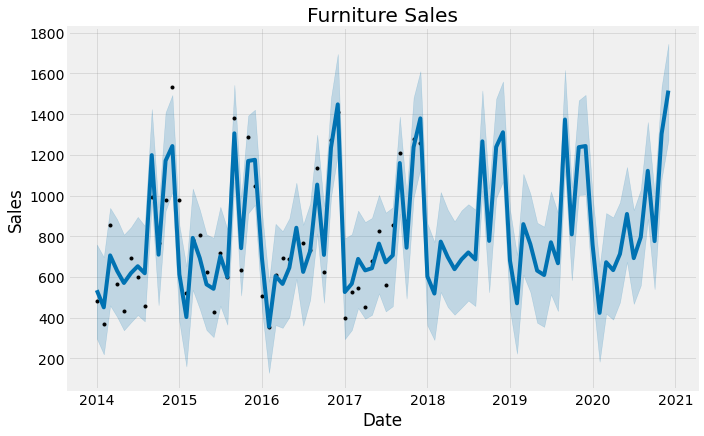

In [30]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')

Text(0.5, 1.0, 'Office Supplies Sales')

<Figure size 1296x432 with 0 Axes>

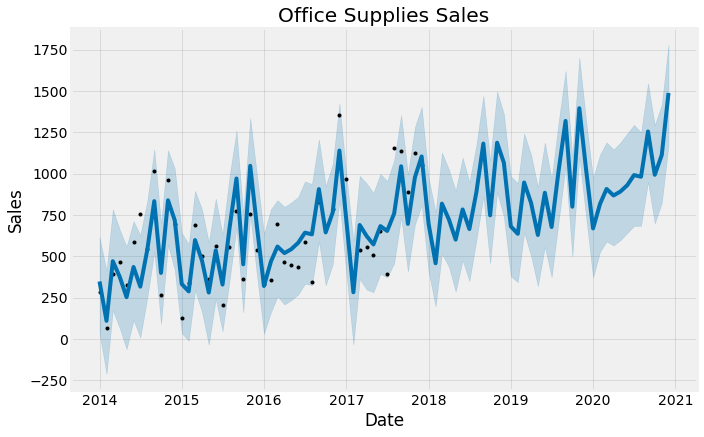

In [31]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales')

### Compare Forecast

Now we have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [36]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,298.076175,759.829699,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,220.406347,697.591166,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,460.520803,939.493400,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,404.158412,883.194284,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,338.515502,808.047513,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


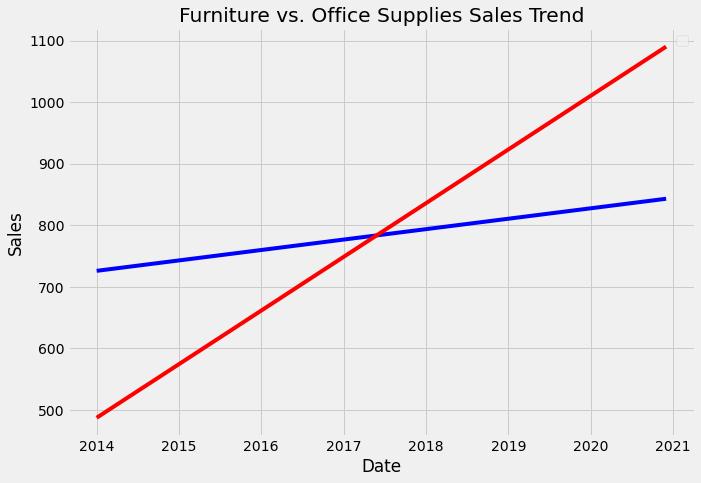

In [38]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

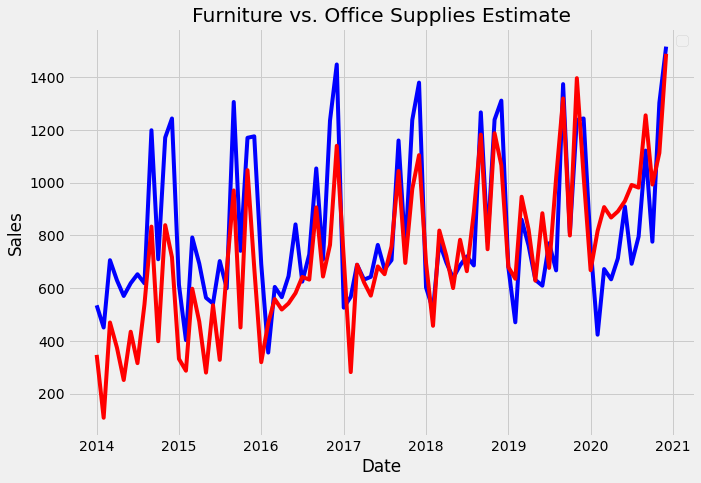

In [39]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

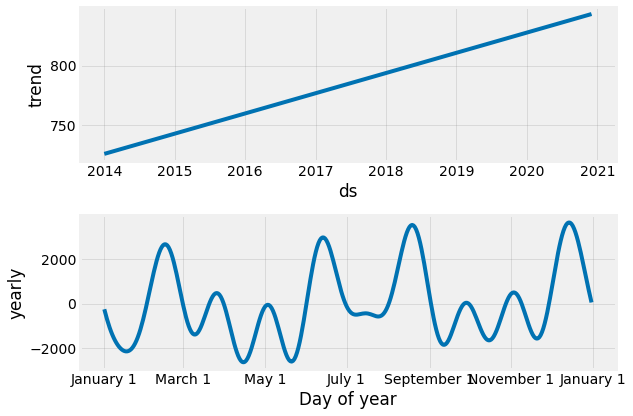

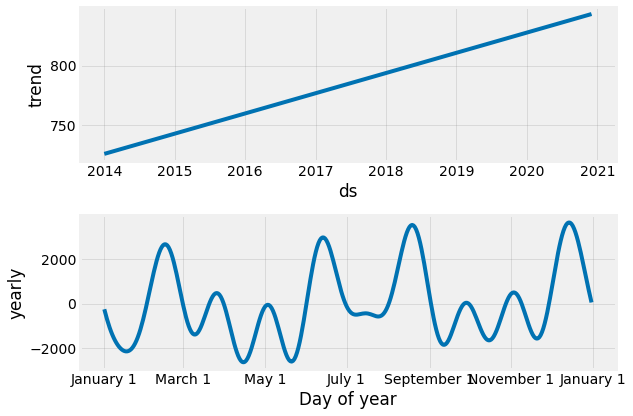

In [40]:
furniture_model.plot_components(furniture_forecast)

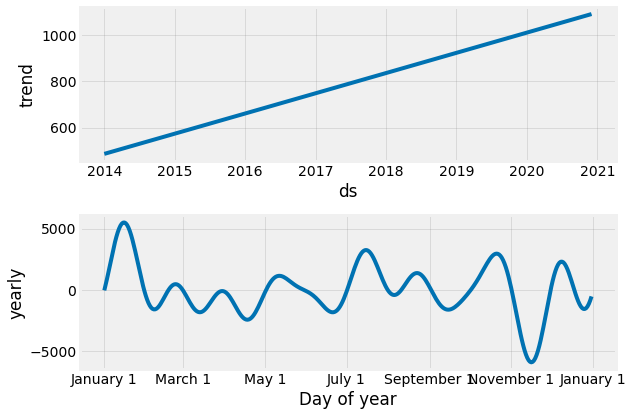

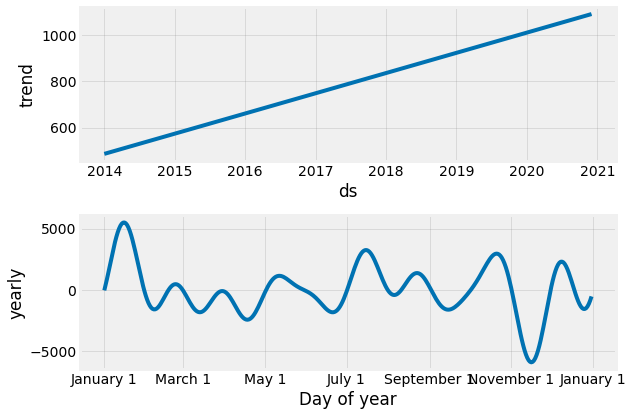

In [41]:
office_model.plot_components(office_forecast)